In [1]:
import numpy as np
import pandas as pd
import do_mpc
from Data_Cleaner import data_loader_main
from SINDy import SINDy_Dynamics
from MPC_Controller import Flow_Dynamics_Model, MPC_Controller
from utilis import MPC_params, setup_mpc

/opt/anaconda3/envs/SUMO_Project/lib/python3.10/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')


In [2]:
flow_all, _, occupancy_all, flow_dt, _, occupancy_dt = data_loader_main(csv_dict='Sim_Results/Ramp_ALIANA')

# import ramp metering data
control_input = pd.read_csv('Results/Meter_Rate_ALIANA.csv')

# remove the first 5 seconds
# flow_all = flow_all.iloc[5:, :].reset_index(drop=True)
# flow_dt = flow_dt.iloc[5:, :].reset_index(drop=True)
# occupancy_all = occupancy_all.iloc[5:, :].reset_index(drop=True)
# occupancy_dt = occupancy_dt.iloc[5:, :].reset_index(drop=True)
# control_input = control_input.iloc[5:, :].reset_index(drop=True)

In [3]:
control_input = control_input/10

In [4]:
equations = SINDy_Dynamics(x=occupancy_all, dx=occupancy_dt, u= control_input)

In [5]:
equations

['-0.022559 * x0**2 + 0.092502 * x0 * x1 + 0.009829 * x0 * x4 + -0.021119 * x0 * x5 + -0.004669 * x0 * x6 + -0.002823 * x0 * u7 + -0.125660 * x1 * x2 + 0.017677 * x1 * x5 + -0.009960 * x1 * x6 + 0.067439 * x2**2 + -0.010688 * x2 * x3 + -0.011765 * x2 * x4 + 0.019004 * x2 * x6 + 0.003131 * x3 * u7',
 '-0.008738 * x0**2 + 0.042922 * x0 * x1 + -0.097402 * x0 * x2 + 0.008425 * x0 * x3 + 0.005090 * x0 * x4 + 0.017373 * x0 * x6 + -0.002953 * x0 * x7 + 0.003240 * x0 * u6 + 0.004538 * x1 * x3 + 0.007223 * x1 * x4 + -0.010786 * x1 * x5 + -0.014481 * x1 * x6 + 0.047710 * x2**2 + -0.015938 * x2 * x4 + 0.007000 * x2 * x5 + 0.003286 * x2 * x7 + -0.003588 * x3 * u6 + 0.002269 * x4**2 + -0.004423 * x4 * x5 + 0.003876 * x5**2',
 '0.009506 * x0**2 + -0.004012 * x0 * x1 + -0.036524 * x0 * x2 + 0.006565 * x0 * x6 + 0.012641 * x1**2 + -0.005539 * x1 * x3 + -0.004038 * x1 * x4 + 0.010658 * x1 * x5 + -0.007485 * x1 * x6 + 0.020334 * x2**2 + -0.002357 * x2 * x5 + 0.002104 * x3 * x5 + -0.004469 * x4 * x5 + 0.

In [6]:
# configure dynamics model
model = Flow_Dynamics_Model(equations)

In [7]:
# configure MPC Contorller
mpc = MPC_Controller(model=model, params=MPC_params, setup_mpc= setup_mpc, silence_solver=False)

In [8]:
mpc.reset_history()

In [9]:
x_0 = np.array(occupancy_all.iloc[0,:])

In [10]:
x_0

array([0.47833333, 0.61      , 0.58      , 0.82333333, 0.84      ,
       1.00333333, 0.79666667, 0.91666667])

In [11]:
mpc.x0 = x_0

In [12]:
mpc.set_initial_guess()

In [13]:
x_t = np.array(occupancy_all.iloc[0,:])

In [14]:
x_t

array([0.47833333, 0.61      , 0.58      , 0.82333333, 0.84      ,
       1.00333333, 0.79666667, 0.91666667])

In [15]:
u_0 = mpc.make_step(x_t)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      952
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      680

Total number of variables............................:      192
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      136
                     variables with only upper bounds:        0
Total number of equality constraints.................:      136
Total number of inequality c

In [16]:
mpc.opt_x_num['_x', 1]

[[DM([0.54204, 0.569657, 0.581043, 0.79541, 0.872394, 1.20059, 0.562114, 12.3976]),
  DM([0.626256, 0.519969, 0.580036, 0.71228, 0.833835, 1.8795, 2.21697, 28.2801]),
  DM([0.626256, 0.519969, 0.580036, 0.71228, 0.833835, 1.8795, 2.21697, 28.2801]),
  DM([0.626256, 0.519969, 0.580036, 0.71228, 0.833835, 1.8795, 2.21697, 28.2801])]]

In [17]:
np.round(u_0,0) * 10

array([[ 430.],
       [ 430.],
       [ 430.],
       [ 210.],
       [ 220.],
       [1800.],
       [1000.],
       [1800.]])

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [19]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
# sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [20]:
%%capture
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()
for g in [mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='x0', axis=ax[0])
    g.add_line(var_type='_x', var_name='x1', axis=ax[0])
    g.add_line(var_type='_x', var_name='x2', axis=ax[0])
    g.add_line(var_type='_x', var_name='x3', axis=ax[0])
    g.add_line(var_type='_x', var_name='x4', axis=ax[0])
    g.add_line(var_type='_x', var_name='x5', axis=ax[0])
    g.add_line(var_type='_x', var_name='x6', axis=ax[0])
    g.add_line(var_type='_x', var_name='x7', axis=ax[0])
    

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='u0', axis=ax[1])
    g.add_line(var_type='_u', var_name='u1', axis=ax[1])
    g.add_line(var_type='_u', var_name='u2', axis=ax[1])
    g.add_line(var_type='_u', var_name='u3', axis=ax[1])
    g.add_line(var_type='_u', var_name='u4', axis=ax[1])
    g.add_line(var_type='_u', var_name='u5', axis=ax[1])
    g.add_line(var_type='_u', var_name='u6', axis=ax[1])
    g.add_line(var_type='_u', var_name='u7', axis=ax[1])


ax[0].set_ylabel('Flow')
ax[1].set_ylabel('')
ax[1].set_xlabel('time [min]')

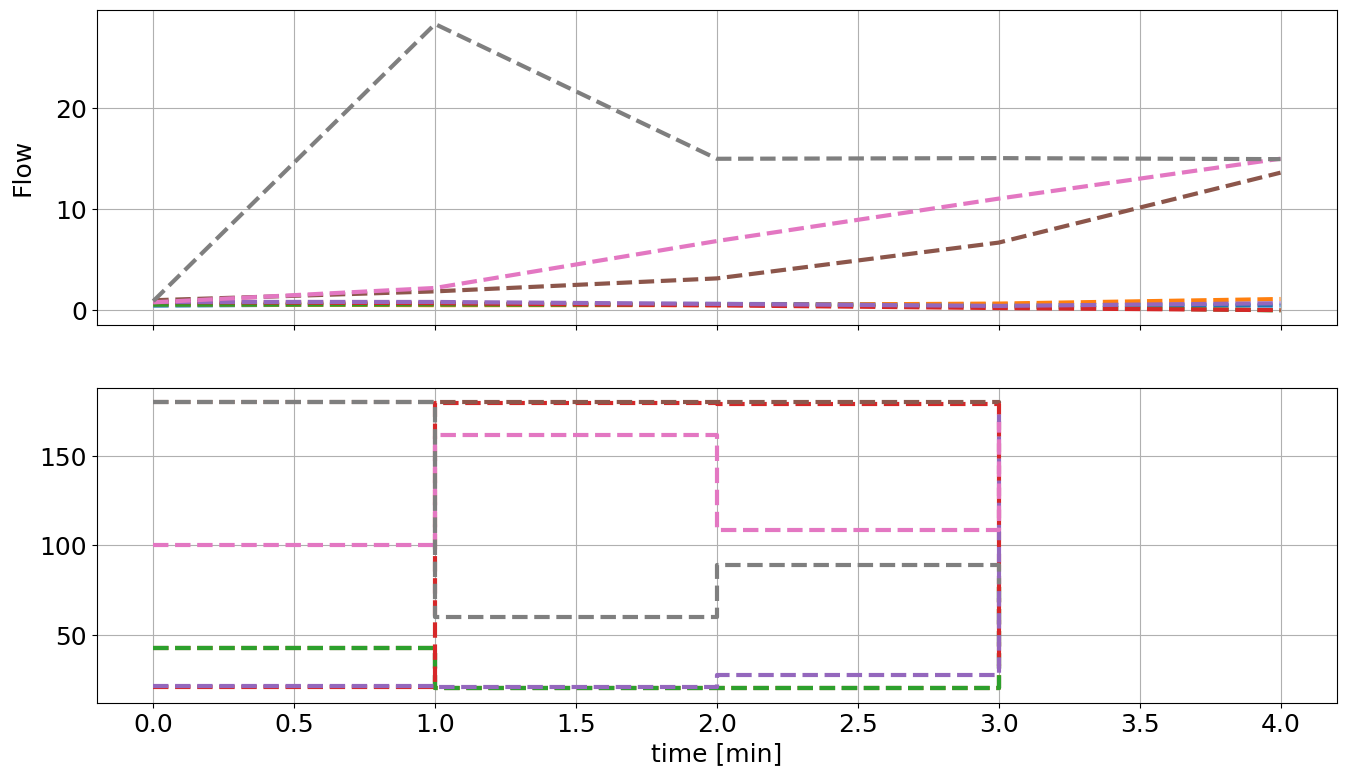

In [21]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig